# HallThruster.jl Tutorial

HallThruster is an efficient 1D fluid model to simulate Hall Thruster discharges. 
This tutorial will show you how to get started with HallThruster.jl and will compare our results to the Landmark study. Detailed information can be found in the [Documentation](https://um-pepl.github.io/HallThruster.jl/dev/).

First install HallThruster.jl according to the Readme instructions. Then load it:

In [1]:
using HallThruster

Let's also load Plots for visualization:

In [2]:
using Plots

Let's try and replicate the LANDMARK benchmarks. 

Let us define the function `run_landmark()` as a helper function. The most important arguments are `end_time; ncells, nsave, dt`. When increasing the amount of cells, the timestep has to be reduced accordingly to satisfy the CFL condition. `nsave` specifies the amount of times the solution is saved in constant time intervals. 

Here we have the Landmark source terms and energy loss terms given as a standard, and we can select one of the 3 test cases to run. We initialize a new simulation and define the domain as twice the thruster length, as evident by the argument `domain = (0.0, 0.05)`. The default flux is set to `rusanov` and the time marching algorithm from DifferentialEquations.jl for the heavy species is a strong stability preserving Runge Kutta scheme of second order `SSPRK22`. 

In [35]:
function run_landmark(end_time = 0.0002; ncells = 100, nsave = 2, dt = 1e-8, case = 1)

    domain = (0.0, 0.05)

    #Landmark cases loss frequencies
    αϵ_in, αϵ_out = if case == 1
        (1.0, 1.0)
    elseif case == 2
        (0.5, 1.0)
    elseif case == 3
        (0.4, 1.0)
    end

    WENO = false
    reconstruct = false
    flux = HallThruster.rusanov
    limiter = HallThruster.no_limiter

    scheme = HallThruster.HyperbolicScheme(flux, limiter, reconstruct, WENO)

    ϵ_anode = 3.0
    ϵ_cathode = 3.0

    # Define the length over which the anomalous transport, wall collision frequency, and wall loss coefficients change
    transition_function = HallThruster.LinearTransition(1e-3, 0.0)

    config = HallThruster.Config(;
        ncharge = 1,
        anode_Te = 2/3 * ϵ_anode,
        cathode_Te = 2/3 * ϵ_cathode,
        discharge_voltage = 300.0,
        ionization_model = HallThruster.LandmarkIonizationLookup(),
        excitation_model = HallThruster.LandmarkExcitationLookup(),
        electron_neutral_model = HallThruster.LandmarkElectronNeutral(),
        electron_ion_collisions = false,
        wall_loss_model = HallThruster.ConstantSheathPotential(-20, αϵ_in, αϵ_out),
        wall_collision_freq = 1.0 * 1e7,
        energy_equation = :LANDMARK,
        neutral_velocity = 150.0,
        neutral_temperature = 0.0,
        ion_temperature = 0.0,
        thruster = HallThruster.SPT_100,
        anode_mass_flow_rate = 5e-6,
        scheme,
        domain,
        WENO,
        transition_function,
    )

    @time sol = HallThruster.run_simulation(config, dt, end_time, ncells, nsave)
    return sol
end

run_landmark (generic function with 2 methods)

Now we can use `run_landmark()` to perform simulations. Running a millisecond with 200 cells takes 15 to 30 seconds.

In [34]:
sol = run_landmark(1e-3; ncells=200, nsave=10000, case = 1, dt = 0.9e-8)

 20.158517 seconds (256.78 k allocations: 318.624 MiB, 2.31% gc time)


Hall thruster solution with 10000 saved frames
Retcode: Success
End time: 0.001 seconds

`sol` is a `HallThrusterSolution` object. This mimics a standard DifferentialEquations `ODESolution` object and has the following fields
- `t`: The times at which the solution was saved
- `u`: A vector of solution matrices of length `nsave`. This contains the main state variables: $\rho_n$, $\rho_i$, $\rho_i u_i$, and $n_e\epsilon$
- `savevals`: A vector of NamedTuples containing some auxilliary variables including $\phi$, $n_e$, $Tev$, $\nu_{AN}$ , $\nu_{en}$, $\nu_{ei}$, and $\mu$
- `retcode`: A short symbol describing how the solution ended. Generally this should be `:success`.
- `destats`: Some DifferentialEquations.jl solver statistics
- `params`: The params that the simulation was run with.

HallThruster has some built-in plotting and postprocessing faculties. Firstly, we can type `plot(sol, frame; case)` To plot the solution at the given frame (from 1 to nsave) and (optionally) compare to the LANDMARK benchmarks.

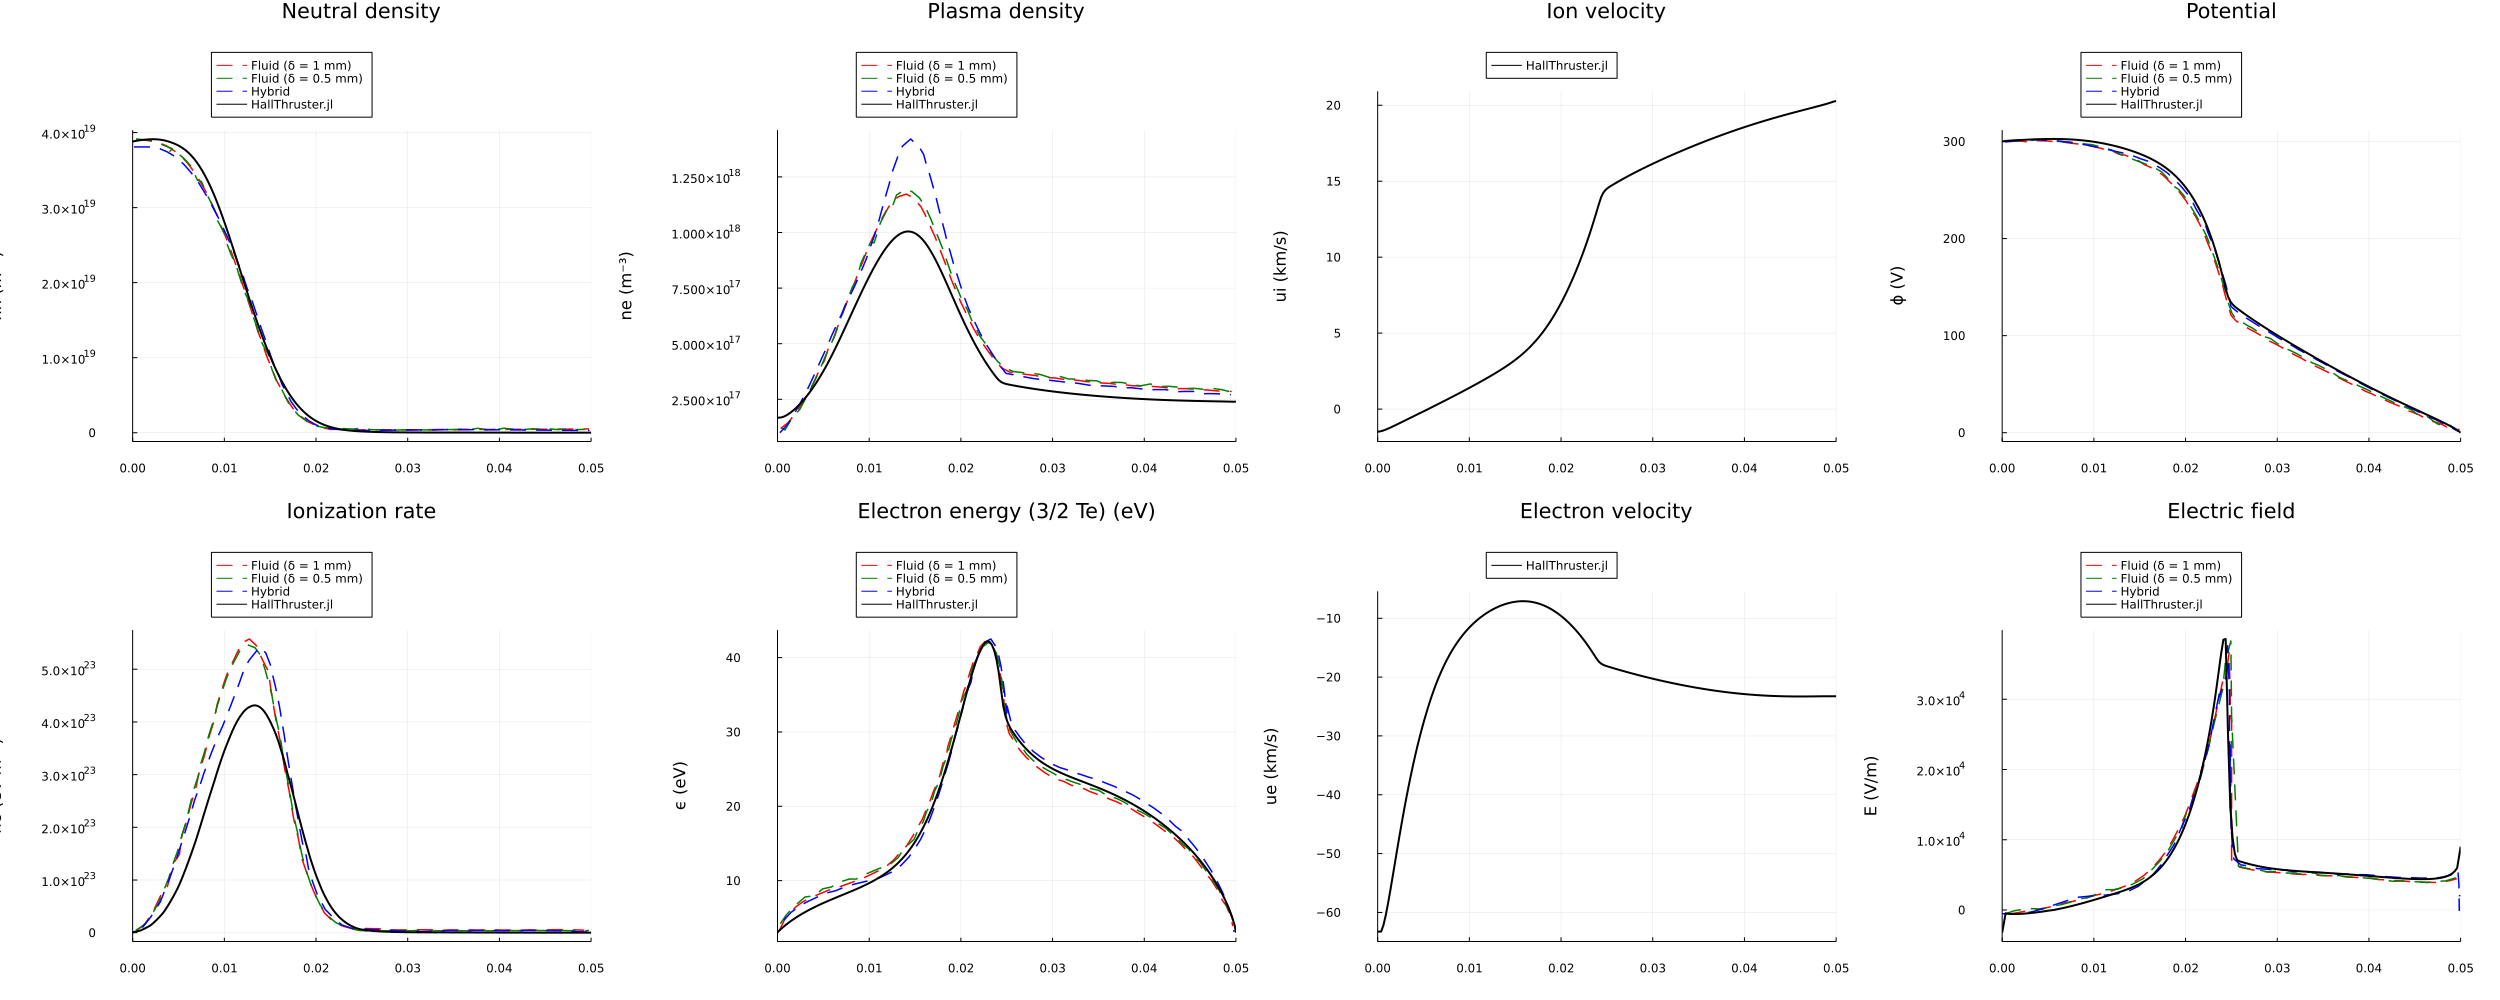

In [36]:
plot(sol; case = 1)

This doesn't look too similar to the benchmark. However, Hall thrusters are strongly oscillatory devices, and we only plotted the last frame. Let's look instead at the time averaged behavior. For this, we use `plot_timeaveraged(sol, starting_frame, case)`, where `starting_frame` is the frame at which we start the averaging.

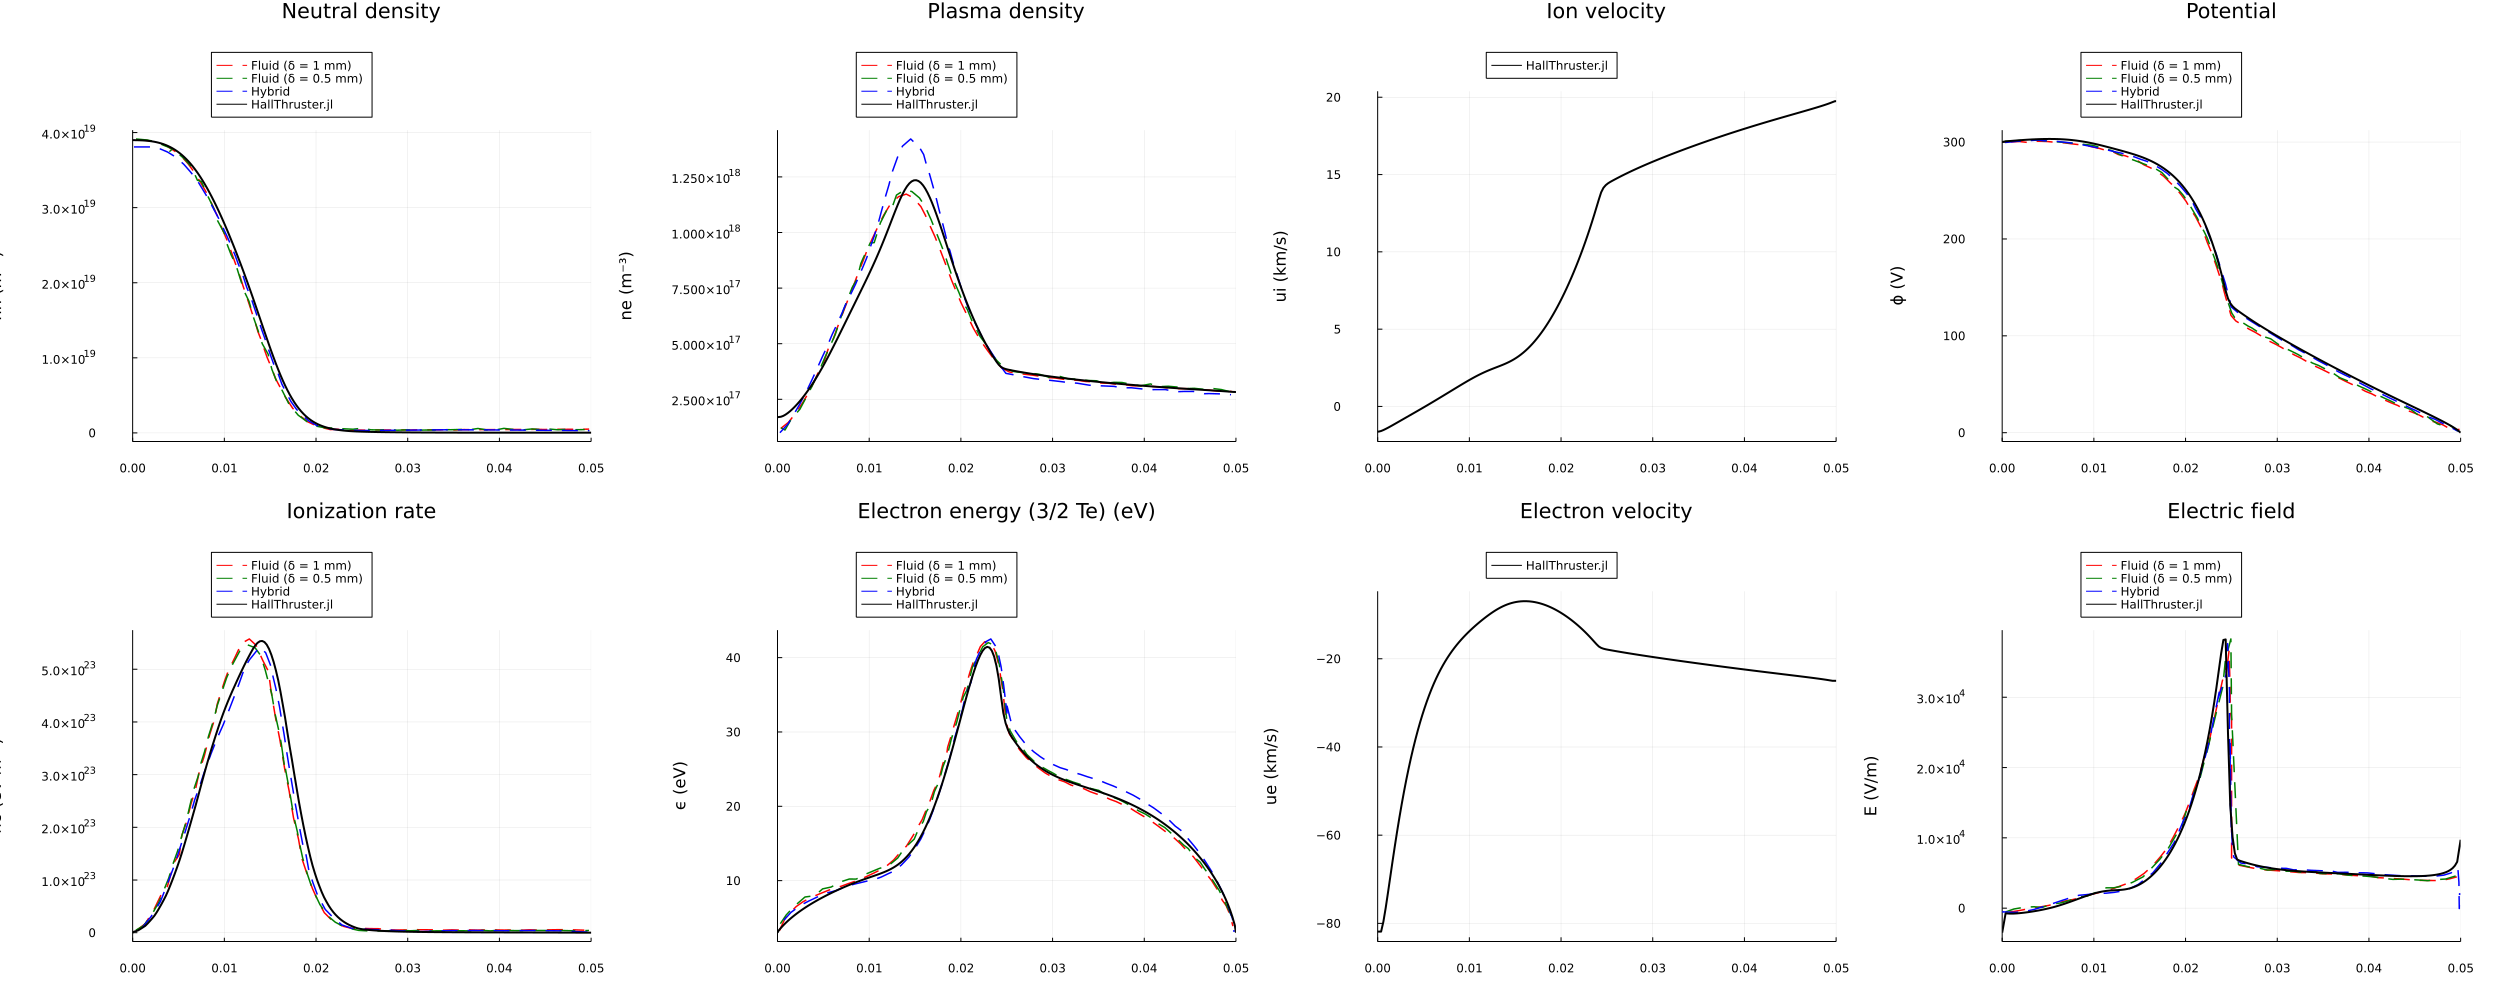

In [37]:
HallThruster.plot_timeaveraged(sol, 1; case=1)

This looks better. We can also check the other LANDMARK cases: Below is the time-averaged behavior of case 2:

 26.144539 seconds (256.78 k allocations: 318.624 MiB, 0.61% gc time)


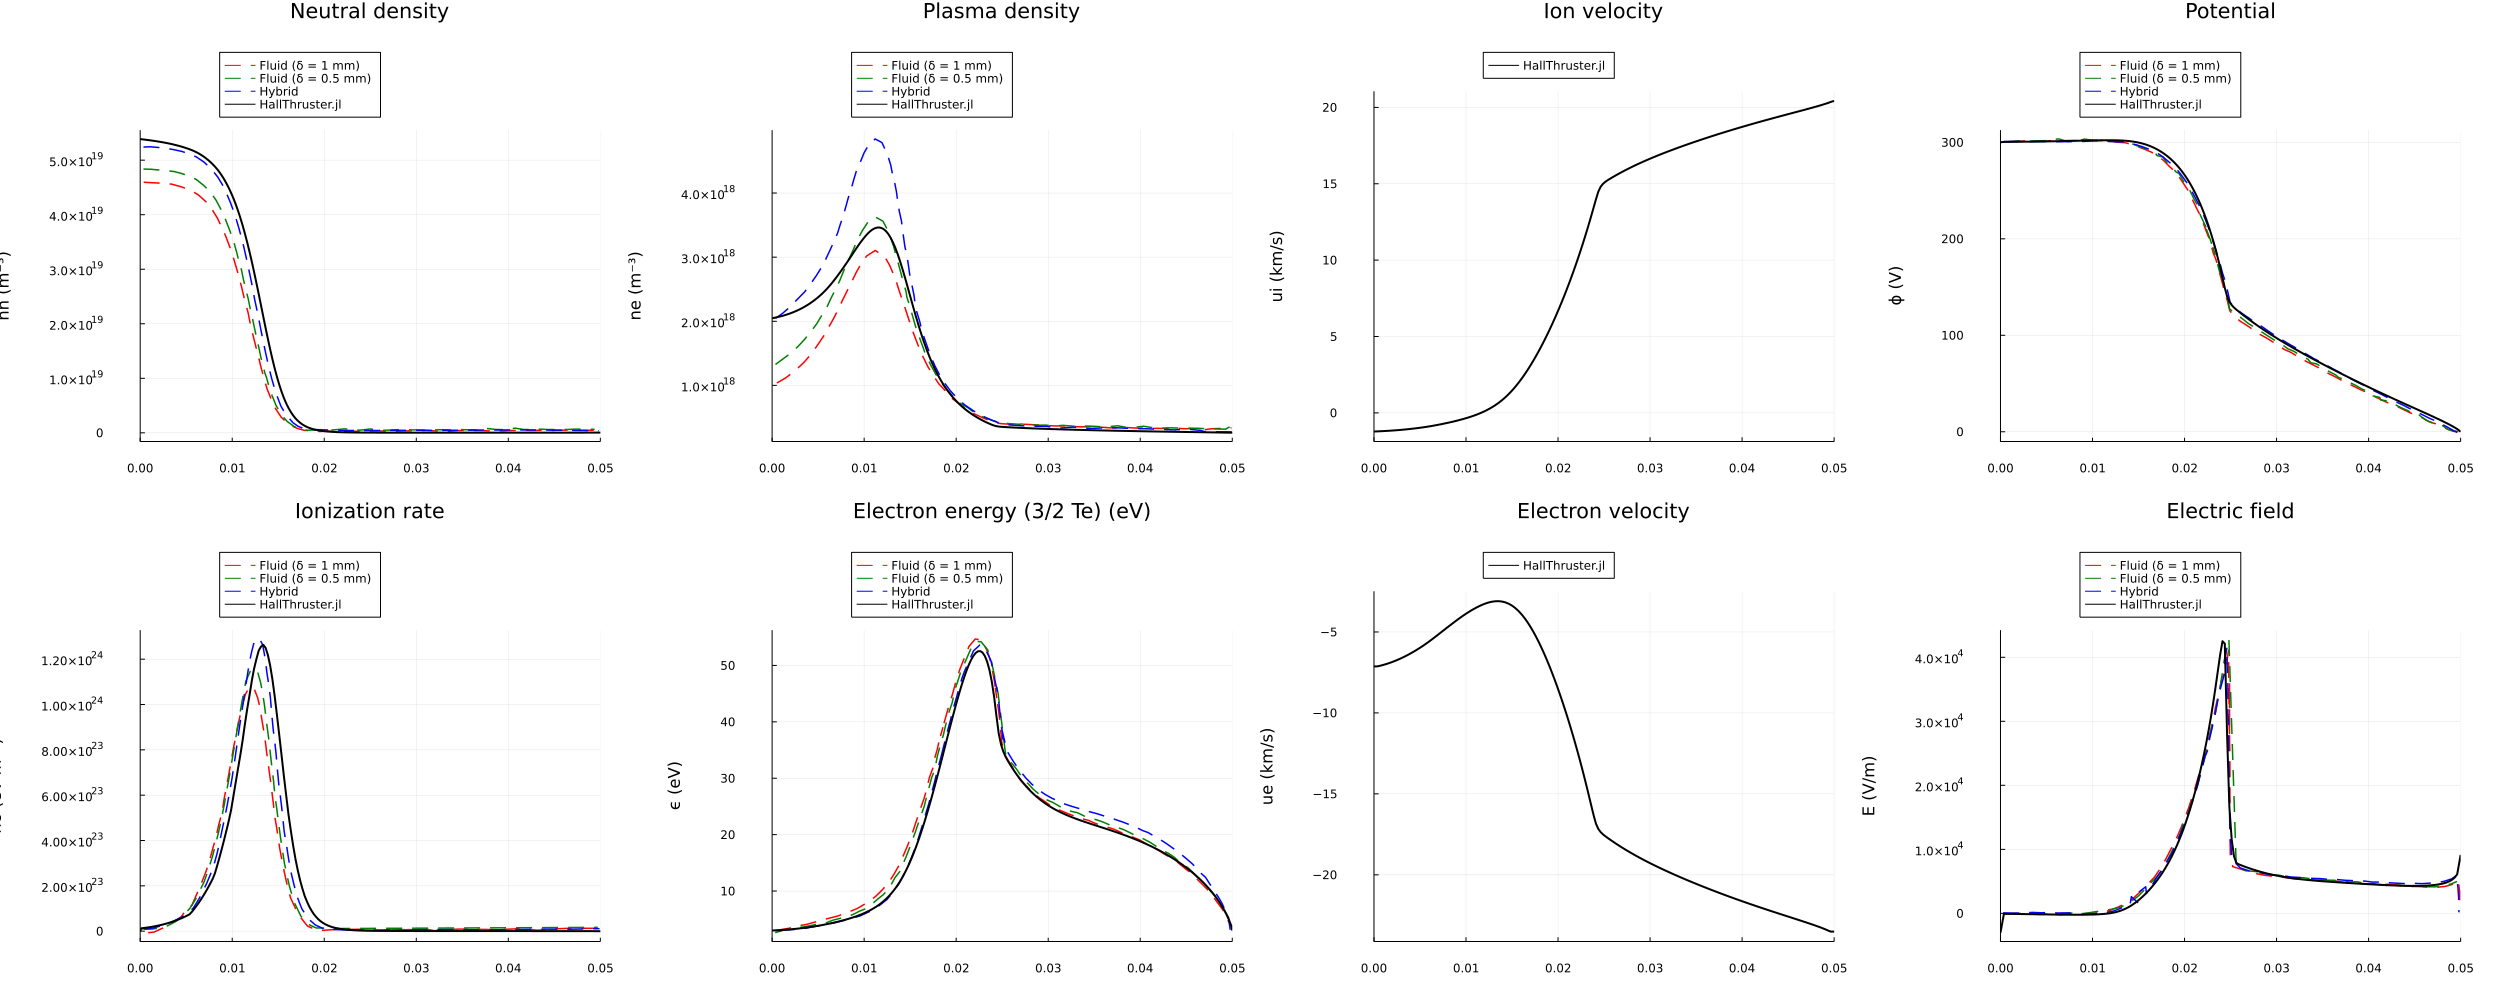

In [38]:
sol_case2 = run_landmark(1e-3; ncells=200, nsave=10000, case = 2, dt = 0.7e-8);
HallThruster.plot_timeaveraged(sol_case2, 1; case=2)

And case 3: 

 24.671750 seconds (76.77 k allocations: 33.235 MiB)


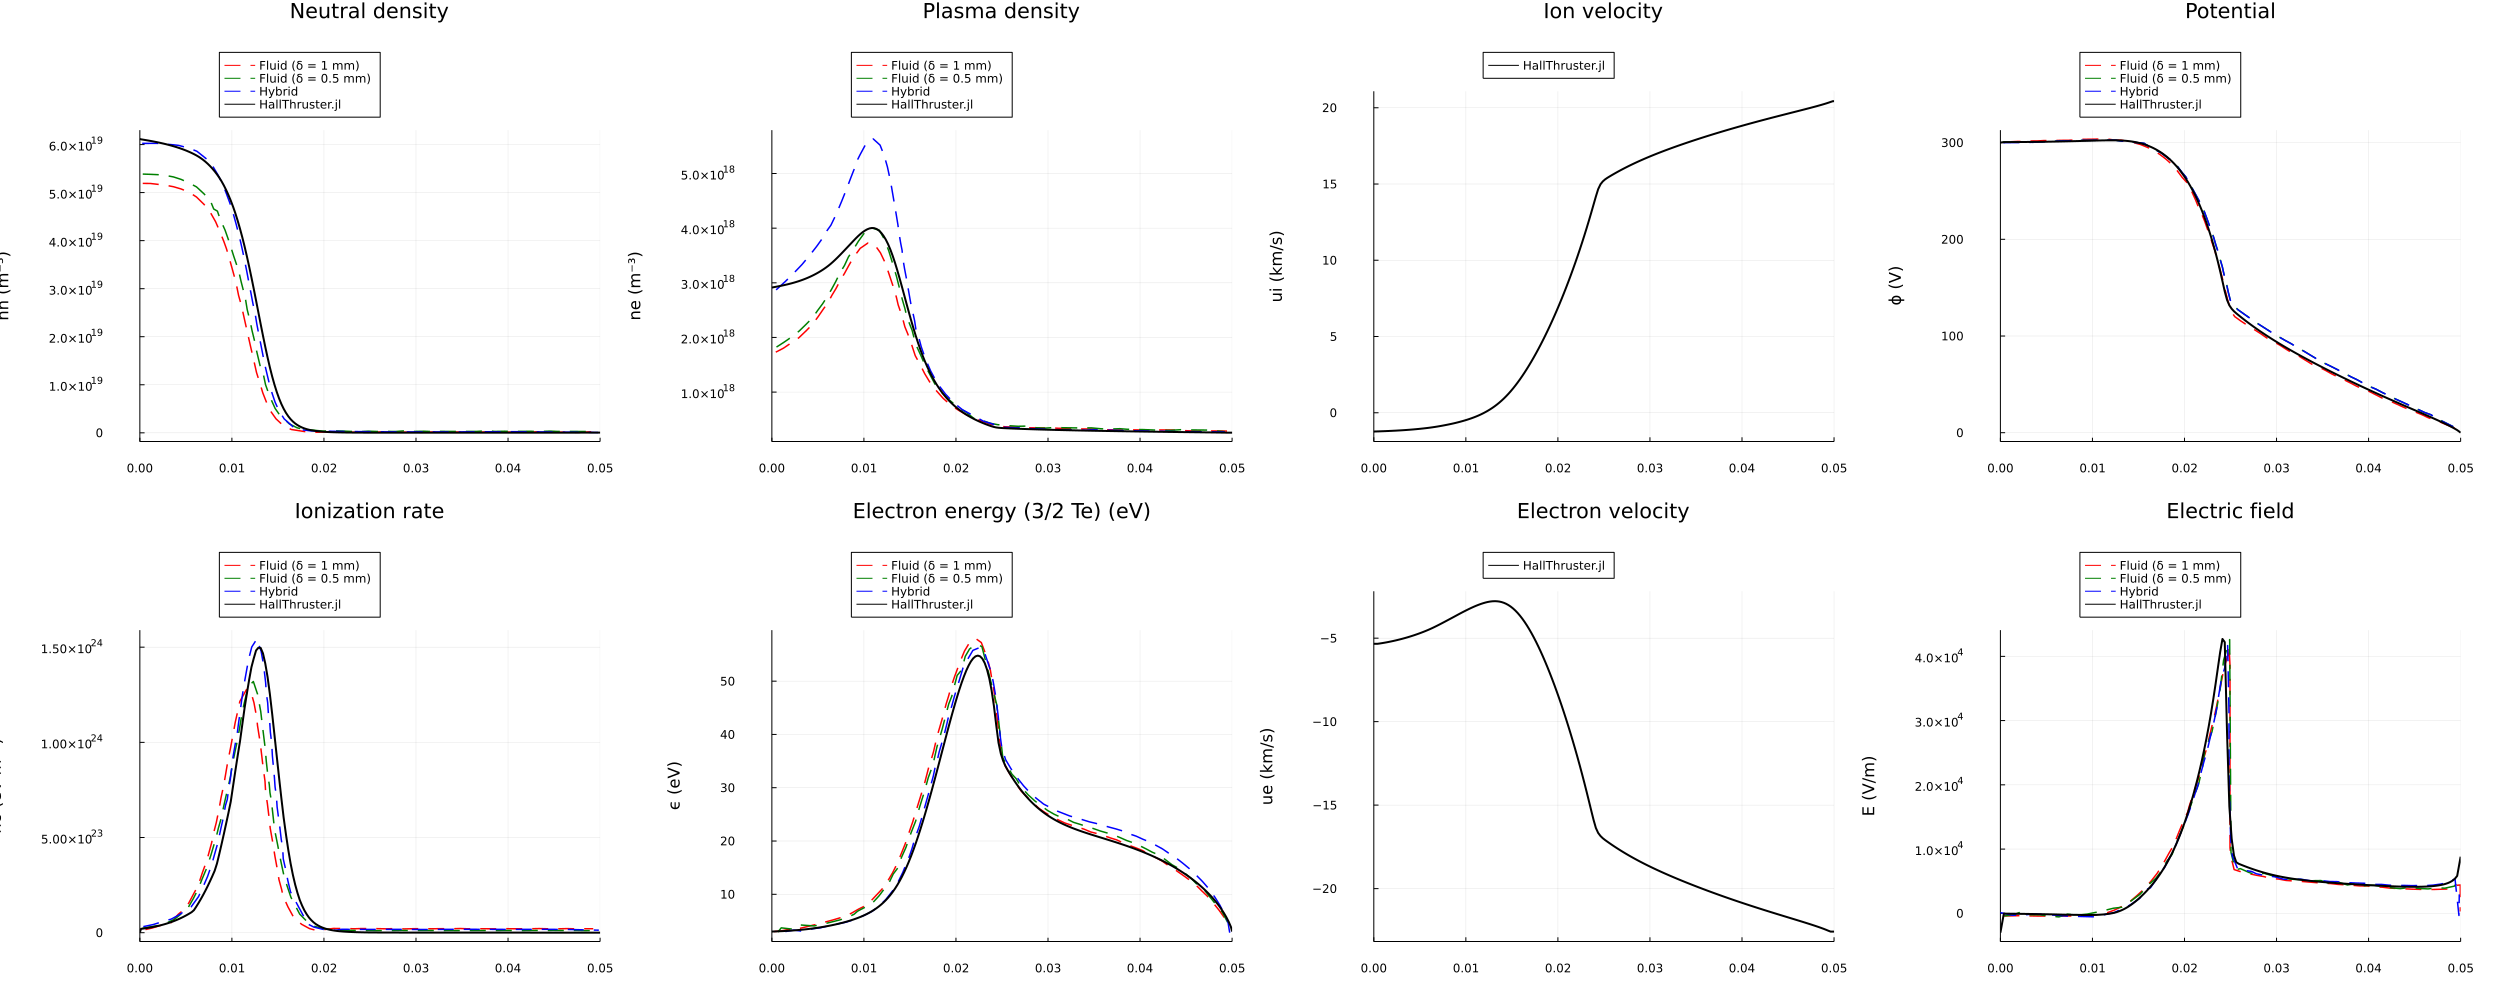

In [39]:
sol_case3 = run_landmark(1e-3; ncells=200, nsave=1000, case = 3, dt = 0.7e-8);
HallThruster.plot_timeaveraged(sol_case3, 1; case=3)